In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports


In [24]:

from bioreaction.simulation.manager import simulate_steady_states
from functools import partial
from typing import Optional, Tuple
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'gpu')
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.70"

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


root_dir = '..'

In [25]:
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.data.data_format_tools.manipulate_fasta import load_seq_from_FASTA
from synbio_morpher.utils.evolution.evolver import Evolver
from synbio_morpher.utils.evolution.mutation import implement_mutation, apply_mutation_to_sequence, get_mutation_type_mapping, reverse_mut_mapping
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.misc.numerical import add_recursively
from synbio_morpher.utils.misc.helper import vanilla_return
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.results.writer import DataWriter
from synbio_morpher.srv.io.loaders.circuit_loader import load_circuit
from synbio_morpher.srv.io.manage.script_manager import script_preamble

# Find good starting circuits


## Load data


In [26]:
og_dir = '../data/ensemble_mutation_effect_analysis/2023_07_15_192831/generate_species_templates'
fn = '../data/ensemble_mutation_effect_analysis/2023_07_17_105328/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
data['mutation_type'] = data['mutation_type'].str.strip('[]').str.split(',').apply(lambda x: [int(xx) for xx in x if xx])
data['mutation_positions'] = data['mutation_positions'].str.strip('[]').str.split(',').apply(lambda x: [int(xx) for xx in x if xx])

In [27]:
config = load_json_as_dict(os.path.join(fn.split('summarise')[
                           0], 'mutation_effect_on_interactions_signal', 'experiment.json'))
config = config['config_filepath']
config['experiment']['purpose'] = 'tests'

In [28]:
config['simulation']['device'] = 'gpu'

## Select starting candidate

We want to start with a circuit that has high adaptability, so a circuit that has high signal sensitivity and precision. We'll use the non-signal species $RNA_1$ and $RNA_2$ as the outputs.

One thing to look out for is that because precision is often then inverse of sensitivity, it will be much larger typically, so selecting the largest for both should give preference to sensitivity.


In [29]:
signal_species = config['signal']['inputs']

filt = (
    (data[get_true_interaction_cols(data, 'energies')].sum(axis=1) != 0) &
    (data['sample_name'].isin(signal_species) != True) &
    (data['overshoot'] > 0)
)

percentile = 0.9
sensitivity_range = data[filt]['sensitivity_wrt_species-6'] > (data[filt]['sensitivity_wrt_species-6'].max() *
                                                               percentile)
starting_circ_rows = data[filt][sensitivity_range].sort_values(
    by=['sensitivity_wrt_species-6', 'precision_wrt_species-6'], ascending=False)

print(
    f'Picking circuits that have a sensitivity of at least {data[filt]["sensitivity_wrt_species-6"].max() * percentile}')

len(starting_circ_rows)

Picking circuits that have a sensitivity of at least 0.36505494


13

Text(0, 0.5, 'Precision')

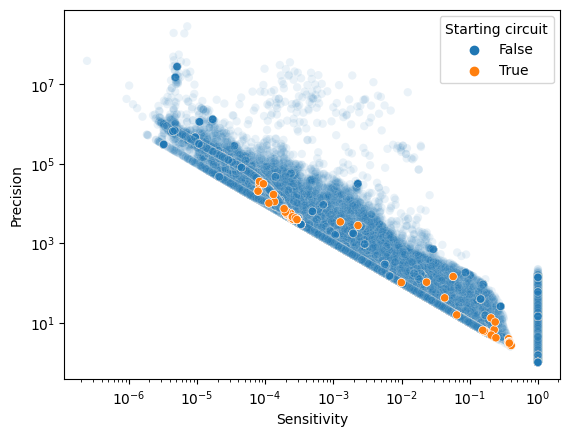

In [30]:

data['Starting circuit'] = (data['circuit_name'].isin(starting_circ_rows['circuit_name'])) & \
    (data['mutation_name'].isin(starting_circ_rows['mutation_name'])) & filt

sns.scatterplot(
    data.sort_values(by='Starting circuit'), x='sensitivity_wrt_species-6', y='precision_wrt_species-6',
    hue='Starting circuit', alpha=((data.sort_values(by='Starting circuit')['Starting circuit'] + 0.1)/1.1)
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sensitivity')
plt.ylabel('Precision')

# Monte Carlo optimisation

We want to push circuits into ranges of higher sensitivity


## Optimisation function


In [31]:
s_target = 1
p_target = 10

def loss_func(s0, p0, s1, p1):
    
    dp = p1 - p0
    ds = s1 - s0
    
    return ds, dp

## Optimisation loop


### Initialise and set up run

In [32]:
config['mutations_args'] = {
    'algorithm': 'random',
    'mutation_counts': 2,
    'mutation_nums_within_sequence': [1],
    'mutation_nums_per_position': 1,
    'concurrent_species_to_mutate': 'single_species_at_a_time',
    'seed': 0
}
config['simulation']['threshold_steady_states'] = 0.1
config['experiment']['no_numerical'] = False
config['experiment']['no_visualisations'] = True

In [33]:
config, data_writer = script_preamble(prepare_config(config))

modeller = CircuitModeller(data_writer, config)
evolver = Evolver(data_writer, mutation_type='random', sequence_type='RNA', seed=0)

### Sim funcs

In [34]:


def mutate(circuits: list, evolver: Evolver, algorithm: str = 'random'):
    
    for c in circuits:
        c = evolver.mutate(
            c, write_to_subsystem=True, algorithm=algorithm)

    return circuits


def simulate(circuits: list, modeller: CircuitModeller, config: dict) -> list:
    
    circuits = modeller.batch_circuits(
        circuits=circuits,
        write_to_subsystem=True,
        batch_size=config['simulation'].get('batch_size', 100),
        methods={
            "compute_interactions": {},
            "init_circuits": {'batch': True},
            "simulate_signal_batch": {'ref_circuit': None,
                                      'batch': config['simulation']['use_batch_mutations']},
            "write_results": {'no_visualisations': config['experiment']['no_visualisations'],
                              'no_numerical': config['experiment']['no_numerical']}
        }
    )
    
    return circuits


def write(circuits: list, modeller: CircuitModeller, config: dict) -> list:
    
    circuits = modeller.batch_circuits(
        circuits=circuits,
        write_to_subsystem=True,
        batch_size=config['simulation'].get('batch_size', 100),
        methods={
            "write_results": {'no_visualisations': False,
                              'no_numerical': True}
        }
    )
    return circuits

    

### Helper funcs

In [35]:


def load_all_analytics(circuit_dirs):
    """ Top (starting) directory should be the starting circuit for each round """
    
    fbn = 'report_signal.json'
    circuits = {}
    for circuit_dir in circuit_dirs:
        if 'mutations' in os.listdir(circuit_dir):
            circuits[os.path.basename(circuit_dir)] = load_all_analytics(
                [os.path.join(circuit_dir, sc) for sc in os.listdir(circuit_dir)]) 
            circuits[os.path.basename(circuit_dir)]['ref_circuit'] = load_json_as_dict(
                os.path.join(circuit_dir, fbn))
        else:
            circuits[os.path.basename(circuit_dir)] = load_json_as_dict(os.path.join(circuit_dir, fbn))
    return circuits


def make_next_name(name: str, subname: str, run: int):
    return name + '_' + str(run) + '_' + subname



### Choosing next circuit

In [36]:

def choose_next(batch: list, choose_max: int = 4, target_species: int = -1):
    
    def make_data(batch, batch_analytics, target_species: int):
        mutated_species = [[(c.name, jax.tree_util.tree_flatten(v.keys())) for k, v in c.mutations.items()] for c in batch]
        d = pd.DataFrame(
            data=np.concatenate(
                [
                    np.asarray([c.name for c in batch])[:, None],
                    np.asarray([c.subname for c in batch])[:, None]
                    # np.asarray(flatten_listlike([[m.template_name for m in jax.tree_util.tree_flatten(c.mutations)[0]] for c in batch]))[:, None]
                ], axis=1
            ),
            columns=['Name', 'Subname']
        )
        d['Sensitivity'] = np.asarray([b['sensitivity_wrt_species-6'][target_species] for b in batch_analytics]) / scale_sensitivity
        d['Precision'] = np.asarray([b['precision_wrt_species-6'][target_species] for b in batch_analytics]) / scale_precision
        d['Circuit Obj'] = batch
        return d
        
    scale_sensitivity = 1
    scale_precision = 1

    batch_analytics = [load_json_as_dict(os.path.join(data_writer.top_write_dir, c.name, 'report_signal.json')) for c in batch]
    batch_analytics = jax.tree_util.tree_map(lambda x: np.float32(x), batch_analytics)
    # starting_analytics = [circuit.result_collector.get_result('signal').analytics for circuit in starting]
    # batch_analytics = [circuit.result_collector.get_result('signal').analytics for circuit in batch]
    data_1 = make_data(batch, batch_analytics, target_species)
    
    rs = data_1[data_1['Subname'] == 'ref_circuit']
    data_1['Parent Sensitivity'] = jax.tree_util.tree_map(lambda n: rs[rs['Name'] == n]['Sensitivity'].iloc[0], data_1['Name'].to_list())
    data_1['Parent Precision'] = jax.tree_util.tree_map(lambda n: rs[rs['Name'] == n]['Precision'].iloc[0], data_1['Name'].to_list())
    
    data_1['dS'] = data_1['Sensitivity'] - data_1['Parent Sensitivity']
    data_1['dP'] = data_1['Precision'] - data_1['Parent Precision']
    
    circuits_chosen = data_1.sort_values(by=['dS', 'dP', 'Sensitivity', 'Precision'])['Circuit Obj'].iloc[:choose_max].to_list()
    data_1['Next selected'] = data_1['Circuit Obj'].isin(circuits_chosen)
    return circuits_chosen, data_1


### Process mutations between runs

In [37]:


def get_mutated_sequences(path, circ_row, mutation_type_mapping) -> dict:
    
    if not os.path.isfile(path):
        path = os.path.join(root_dir, path)
        assert os.path.isfile(path), f'Path {path} is not valid.'
    
    if circ_row['mutation_name'] == 'ref_circuit': 
        return path

    sequences = load_seq_from_FASTA(path, as_type = 'dict')
    mutated_species = circ_row['mutation_name'][:5]
    mutation_types = jax.tree_util.tree_map(lambda x: mutation_type_mapping[x], circ_row['mutation_type'])
    mutated_sequence = apply_mutation_to_sequence(
        sequences[mutated_species], circ_row['mutation_positions'], mutation_types)
    
    sequences[mutated_species] = mutated_sequence
    return sequences

    
def process_for_next_run(circuits: list, data_writer: DataWriter, run: int):
    
    for i, c in enumerate(circuits):
        circuits[i].name = make_next_name(c.name, c.subname, run)
        # sequences = {s.name: s.physical_data for s in c.model.species if s.physical_data}
        sequences = load_seq_from_FASTA(c.data.source, as_type='dict')
        circuits[i].data.source = write_mutated_circuit(
            name=circuits[i].name, subname='ref_circuit', sequences=sequences, data_writer=data_writer)
    return circuits
    
    
def write_mutated_circuit(
    name: str, subname: str, sequences, data_writer: DataWriter):
    
    data_writer.subdivide_writing(name)
    if subname != 'ref_circuit':
        data_writer.subdivide_writing(subname, safe_dir_change=False)
    
    new_path = data_writer.output(
        out_name=name,
        out_type='fasta', return_path=True,
        data=sequences, byseq=True
    )
    
    data_writer.unsubdivide()
    return new_path


def make_starting_circuits(starting_circuits: pd.DataFrame, config: dict, data_writer):
    d = {v: v for v in jax.tree_util.tree_flatten(get_mutation_type_mapping('RNA'))[0]}
    mutation_type_mapping_rev = jax.tree_util.tree_map(lambda x: reverse_mut_mapping(x), d)

    circuits = []
    for i, circ_row in starting_circuits.iterrows():
        curr_config = config
        sequences = get_mutated_sequences(circ_row['path_to_template_circuit'], circ_row, mutation_type_mapping_rev)
        path = write_mutated_circuit(
            name=circ_row['circuit_name'],
            subname=circ_row['mutation_name'],
            sequences=sequences,
            data_writer=data_writer)
        curr_config['data_path'] = path
        circuit = construct_circuit_from_cfg(prev_configs=None, config_file=curr_config) 
        circuit.name = make_next_name(circ_row['circuit_name'], circ_row['mutation_name'], i)
        circuits.append(circuit)
        
    return circuits


## Start loop

In [38]:
assert ('gpu' in str(jax.devices())) or ('GPU' in str(jax.devices())), 'Maybe use a GPU'

In [43]:
target_species = -1
choose_max = 20
total_steps = 3

starting = make_starting_circuits(starting_circ_rows.iloc[:choose_max], config, data_writer)
starting = simulate(starting, modeller, config)

circuit_manager.py:batch_circuits():567: 	From 13 circuits, a total of 13 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():574: 		Starting new round of viable circuits (0 - 13 / 13) WARNING
circuit_manager.py:batch_circuits():592: 		Making subcircuits 0 - 13 took 2.2e-05s WARNING
circuit_manager.py:batch_circuits():598: 	Batching 0 - 20000 circuits (out of 0 - 13 (total: 13)) (Circuits: 0 - 13 of 13) WARNING
circuit_manager.py:run_batch():629: 		Running 13 Subcircuits - toy_mRNA_circuit_11726_1042709_RNA_0_m3-8: compute_interactions WARNING
circuit_manager.py:run_batch():665: 		Method compute_interactions took 0.04353s WARNING
circuit_manager.py:run_batch():629: 		Running 13 Subcircuits - toy_mRNA_circuit_11726_1042709_RNA_0_m3-8: init_circuits WARNING


Done:  0:00:41.681107


circuit_manager.py:run_batch():665: 		Method init_circuits took 42.059759s WARNING
circuit_manager.py:run_batch():629: 		Running 13 Subcircuits - toy_mRNA_circuit_11726_1042709_RNA_0_m3-8: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():490: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():340: 		Simulating signal took 40.712977s WARNING


Done:  0:00:40.641242


circuit_manager.py:simulate_signal_batch():396: 		Calculating analytics took 2.944249s WARNING
circuit_manager.py:run_batch():665: 		Method simulate_signal_batch took 44.830395s WARNING
circuit_manager.py:run_batch():629: 		Running 13 Subcircuits - toy_mRNA_circuit_11726_1042709_RNA_0_m3-8: write_results WARNING
circuit_manager.py:run_batch():665: 		Method write_results took 0.108756s WARNING
circuit_manager.py:batch_circuits():612: Single batch: 0:01:27.048528 
Projected time: 87.048528s 
Total time: 0:01:27.048540 WARNING


In [44]:

summary = {}
summary_batch = {}
summary_datas = {}
summary[0] = starting
for step in range(total_steps):
    
    print('\n\nStarting new batch\n\n')

    batch = mutate(starting, evolver, algorithm='all')
    batch = simulate(batch, modeller, config)
    expanded_batchs = []
    for b in batch:
        config['data_path'] = b.data.source
        expanded_batchs.append(flatten_listlike([load_circuit(
            os.path.join(data_writer.top_write_dir, b.name), 
            name=b.name, config=config, load_mutations_as_circuits=True)] for b in batch))
    expanded_batchs = flatten_listlike(flatten_listlike(expanded_batchs))
    starting, summary_data = choose_next(batch=expanded_batchs, choose_max=choose_max, target_species=target_species)
    starting = process_for_next_run(starting, data_writer=data_writer, run=step)
    
    summary[step+1] = starting
    summary_batch[step] = expanded_batchs
    summary_datas[step] = summary_data
    
    for i in range(len(starting)):
        starting[i].subname = 'ref_circuit'



Starting new batch




circuit_manager.py:batch_circuits():567: 	From 13 circuits, a total of 2353 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():574: 		Starting new round of viable circuits (0 - 13 / 13) WARNING
circuit_manager.py:batch_circuits():592: 		Making subcircuits 0 - 2353 took 1.591162s WARNING
circuit_manager.py:batch_circuits():598: 	Batching 0 - 20000 circuits (out of 0 - 2353 (total: 2353)) (Circuits: 0 - 13 of 13) WARNING
circuit_manager.py:run_batch():629: 		Running 2353 Subcircuits - toy_mRNA_circuit_11726_1042709_RNA_0_m3-8: compute_interactions WARNING
circuit_manager.py:run_batch():665: 		Method compute_interactions took 144.181681s WARNING
circuit_manager.py:run_batch():629: 		Running 2353 Subcircuits - toy_mRNA_circuit_11726_1042709_RNA_0_m3-8: init_circuits WARNING


Steady states:  100  iterations.  3672  left to steady out.  0:00:43.320045
Steady states:  200  iterations.  79  left to steady out.  0:01:26.058000
Done:  0:02:08.568953


circuit_manager.py:run_batch():665: 		Method init_circuits took 131.206115s WARNING
circuit_manager.py:run_batch():629: 		Running 2353 Subcircuits - toy_mRNA_circuit_11726_1042709_RNA_0_m3-8: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():490: Signal differs between circuits, but only first signal used for simulation. WARNING


Steady states:  100  iterations.  2  left to steady out.  0:00:45.024552


circuit_manager.py:simulate_signal_batch():340: 		Simulating signal took 89.493624s WARNING


Done:  0:01:29.471653


circuit_manager.py:simulate_signal_batch():396: 		Calculating analytics took 79.96472s WARNING
circuit_manager.py:run_batch():665: 		Method simulate_signal_batch took 171.473486s WARNING
circuit_manager.py:run_batch():629: 		Running 2353 Subcircuits - toy_mRNA_circuit_11726_1042709_RNA_0_m3-8: write_results WARNING
circuit_manager.py:run_batch():665: 		Method write_results took 24.791422s WARNING
circuit_manager.py:batch_circuits():612: Single batch: 0:07:53.250439 
Projected time: 473.25043900000003s 
Total time: 0:07:53.250454 WARNING




Starting new batch




circuit_manager.py:batch_circuits():567: 	From 20 circuits, a total of 3620 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():574: 		Starting new round of viable circuits (0 - 20 / 20) WARNING
circuit_manager.py:batch_circuits():592: 		Making subcircuits 0 - 3620 took 2.35415s WARNING
circuit_manager.py:batch_circuits():598: 	Batching 0 - 20000 circuits (out of 0 - 3620 (total: 3620)) (Circuits: 0 - 20 of 20) WARNING
circuit_manager.py:run_batch():629: 		Running 3620 Subcircuits - toy_mRNA_circuit_11726_1042709_RNA_0_m3-8_0_ref_circuit: compute_interactions WARNING
circuit_manager.py:run_batch():665: 		Method compute_interactions took 223.293491s WARNING
circuit_manager.py:run_batch():629: 		Running 3620 Subcircuits - toy_mRNA_circuit_11726_1042709_RNA_0_m3-8_0_ref_circuit: init_circuits WARNING


Steady states:  100  iterations.  2729  left to steady out.  0:00:52.207024
Steady states:  200  iterations.  586  left to steady out.  0:01:42.255831
Steady states:  300  iterations.  4  left to steady out.  0:02:31.952168
Done:  0:03:21.270537


circuit_manager.py:run_batch():665: 		Method init_circuits took 205.558018s WARNING
circuit_manager.py:run_batch():629: 		Running 3620 Subcircuits - toy_mRNA_circuit_11726_1042709_RNA_0_m3-8_0_ref_circuit: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():490: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():340: 		Simulating signal took 49.416146s WARNING


Done:  0:00:49.334514


circuit_manager.py:simulate_signal_batch():396: 		Calculating analytics took 116.35817s WARNING
circuit_manager.py:run_batch():665: 		Method simulate_signal_batch took 170.816992s WARNING
circuit_manager.py:run_batch():629: 		Running 3620 Subcircuits - toy_mRNA_circuit_11726_1042709_RNA_0_m3-8_0_ref_circuit: write_results WARNING
circuit_manager.py:run_batch():665: 		Method write_results took 33.836338s WARNING
circuit_manager.py:batch_circuits():612: Single batch: 0:10:35.867506 
Projected time: 635.867506s 
Total time: 0:10:35.867532 WARNING




Starting new batch




circuit_manager.py:batch_circuits():567: 	From 20 circuits, a total of 3620 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():574: 		Starting new round of viable circuits (0 - 20 / 20) WARNING
circuit_manager.py:batch_circuits():592: 		Making subcircuits 0 - 3620 took 2.366732s WARNING
circuit_manager.py:batch_circuits():598: 	Batching 0 - 20000 circuits (out of 0 - 3620 (total: 3620)) (Circuits: 0 - 20 of 20) WARNING
circuit_manager.py:run_batch():629: 		Running 3620 Subcircuits - toy_mRNA_circuit_11726_1042709_RNA_0_m3-8_0_ref_circuit_1_ref_circuit: compute_interactions WARNING
circuit_manager.py:run_batch():665: 		Method compute_interactions took 223.62926s WARNING
circuit_manager.py:run_batch():629: 		Running 3620 Subcircuits - toy_mRNA_circuit_11726_1042709_RNA_0_m3-8_0_ref_circuit_1_ref_circuit: init_circuits WARNING


Steady states:  100  iterations.  2371  left to steady out.  0:00:51.297559
Steady states:  200  iterations.  525  left to steady out.  0:01:42.380740
Steady states:  300  iterations.  4  left to steady out.  0:02:32.138727
Done:  0:03:22.240461


circuit_manager.py:run_batch():665: 		Method init_circuits took 206.282638s WARNING
circuit_manager.py:run_batch():629: 		Running 3620 Subcircuits - toy_mRNA_circuit_11726_1042709_RNA_0_m3-8_0_ref_circuit_1_ref_circuit: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():490: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():340: 		Simulating signal took 51.53934s WARNING


Done:  0:00:51.479959


circuit_manager.py:simulate_signal_batch():396: 		Calculating analytics took 117.470833s WARNING
circuit_manager.py:run_batch():665: 		Method simulate_signal_batch took 179.762073s WARNING
circuit_manager.py:run_batch():629: 		Running 3620 Subcircuits - toy_mRNA_circuit_11726_1042709_RNA_0_m3-8_0_ref_circuit_1_ref_circuit: write_results WARNING
circuit_manager.py:run_batch():665: 		Method write_results took 33.652747s WARNING
circuit_manager.py:batch_circuits():612: Single batch: 0:10:45.699624 
Projected time: 645.699624s 
Total time: 0:10:45.699640 WARNING


In [78]:
dt0 = 0.0005
dt1 = 100 * dt0
# tsteps = 
t0 = 0
t1 = 100

num = 100
x = np.interp(np.logspace(0, 2, num=100), [0, 100], [dt0, dt1])
while np.cumsum(x)[-1] < t1:
    x = np.interp(np.logspace(0, 2, num=num), [0, 100], [dt0, dt1])

    num += 1

In [80]:
np.interp(np.logspace(0, 2, num=num), [0, 100], [dt0, dt1])


array([0.000995  , 0.00099525, 0.00099551, ..., 0.04994923, 0.04997461,
       0.05      ])

## Visualise circuit trajectory


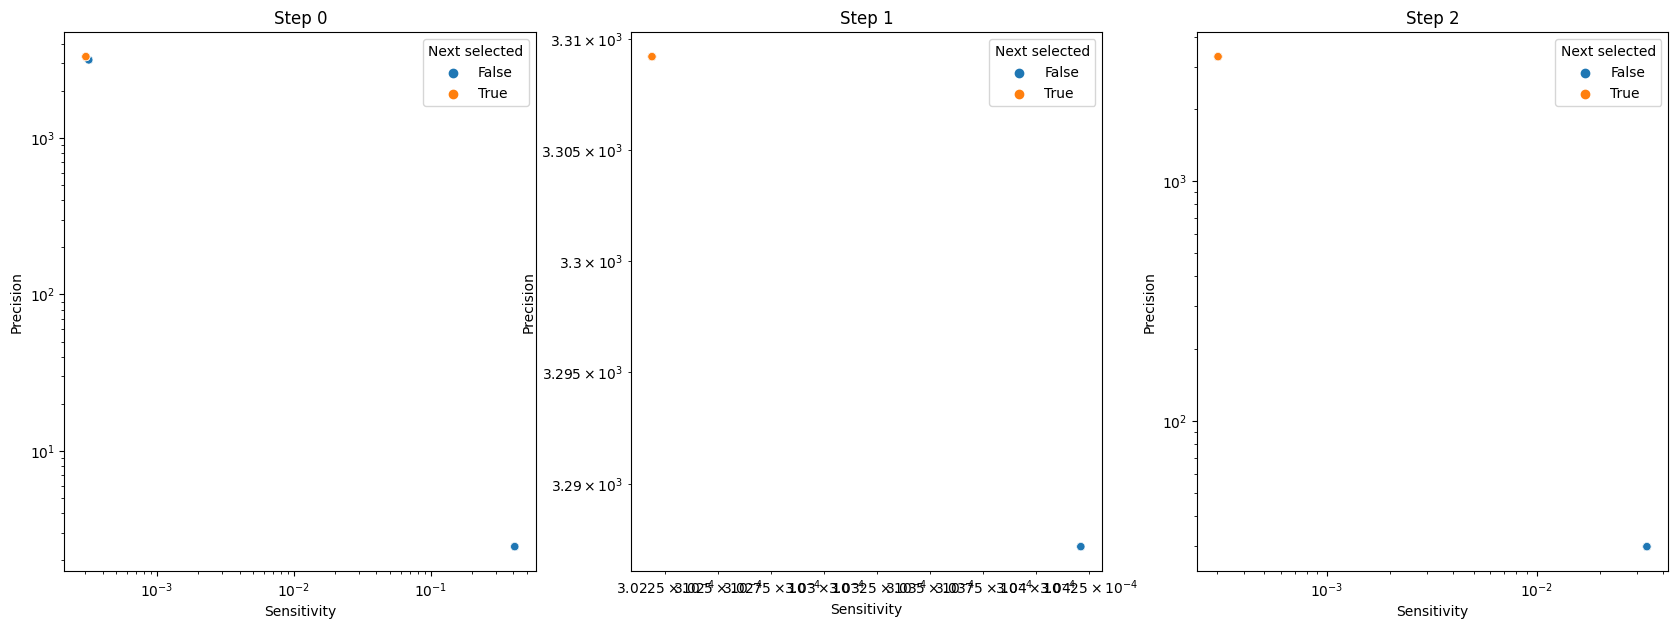

In [42]:

plt.figure(figsize=(len(summary) * 7, 7))
for step, sdata in summary_datas.items():
    ax = plt.subplot(1,len(summary), step+1)
    
    # batch_analytics = [load_json_as_dict(os.path.join(data_writer.top_write_dir, c.name, 'report_signal.json')) for c in circuits] 
    
    # batch_analytics = [circuit.result_collector.get_result('signal').analytics for circuit in circuits]
    
    # d = pd.DataFrame(
    #     data=np.concatenate(
    #         [
    #             np.asarray([b['sensitivity_wrt_species-6'][target_species] for b in batch_analytics]),
    #             np.asarray([b['precision_wrt_species-6'][target_species] for b in batch_analytics]),
    #             np.asarray([c in summary[step] for c in circuits])[:, None]
    #         ],
    #         axis=1
    #     ),
    #     columns=['Sensitivity', 'Precision', 'Next selected']
    # )
    
    sns.scatterplot(sdata.sort_values(by=['Next selected']), x='Sensitivity', y='Precision', hue='Next selected')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step}')